# Creating Environment and Import Libraries

In [1]:
# !pip install torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import shutil 
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
import glob
import random

from torch.utils.data import Dataset , DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


import time
import datetime
import sys

from torch.autograd import Variable
import torch
import numpy as np
import itertools
from tqdm import tqdm_notebook as tqdm
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchsummary import summary
from torchvision.utils import save_image
import pandas as pd
from IPython.display import Image as ImageDisplay

In [5]:
# image_dir = r'C:\Users\EmincanY\Desktop\Pythorch\GAN\img_celeba\images'
# attributes_file = r'C:\Users\EmincanY\Desktop\Pythorch\GAN\img_celeba\list_attr_celeba.csv'
# output_dir = r'C:\Users\EmincanY\Desktop\Pythorch\GAN\img_celeba\preprocessed_dataset_celeba'

In [6]:
# image_dir = r'/content/drive/MyDrive/DataSets/img_celeba/images'
# attributes_file = r'/content/drive/MyDrive/DataSets/img_celeba/list_attr_celeba.csv'
# output_dir = r'/content/drive/MyDrive/DataSets/img_celeba/preprocessed_dataset_celeba'

In [7]:
image_dir = r'/content/drive/MyDrive/DataSets/img_celeba2/images'
attributes_file = r'/content/drive/MyDrive/DataSets/img_celeba2/list_attr_celeba.csv'
output_dir = r'/content/drive/MyDrive/DataSets/img_celeba2/preprocessed_dataset_celeba'

In [8]:
df = pd.read_csv(attributes_file)
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [9]:
df_blackHairFemale = df.loc[df['Black_Hair' ] == 1 & (df['Male'] == -1)].head(200)
df_blondHairFemale = df.loc[df['Blond_Hair' ] == 1 & (df['Male'] == -1)].head(200)

In [10]:
domainA , domainB = [] , []

for index, row in df_blackHairFemale.iterrows():
    domainA.append(row['image_id'])

for index, row in df_blondHairFemale.iterrows():
    domainB.append(row['image_id'])

In [11]:
A_train , A_test , = train_test_split(domainA , test_size = 0.01 , random_state = 53)
B_train , B_test , = train_test_split(domainB , test_size = 0.01 , random_state = 53)

In [12]:
N = min(len(A_train) , len(B_train))
A_train = A_train[:N]
B_train = B_train[:N]

print(f'Images in A {len(A_train)} and B {len(B_train)}')

Images in A 198 and B 198


In [13]:
N = min(len(A_test) , len(B_test))
A_test = A_test[:N]
B_test = B_test[:N]

print(f'Images in A {len(A_test)} and B {len(B_test)}')

Images in A 2 and B 2


In [14]:
A_train_dir = os.path.join(output_dir , 'train/A')
B_train_dir = os.path.join(output_dir , 'train/B')

os.makedirs(A_train_dir , exist_ok = True) # Creating locations.
os.makedirs(B_train_dir , exist_ok = True)

for imageA , imageB in zip(A_train , B_train):
    shutil.copy(os.path.join(image_dir,imageA) , os.path.join(A_train_dir , imageA))
    shutil.copy(os.path.join(image_dir,imageB) , os.path.join(B_train_dir , imageB))

A_test_dir = os.path.join(output_dir,'test/A')
B_test_dir = os.path.join(output_dir,'test/B')

os.makedirs(A_test_dir , exist_ok = True)
os.makedirs(B_test_dir , exist_ok = True)

for imageA , imageB in zip(A_test , B_test):
    shutil.copy(os.path.join(image_dir, imageA) , os.path.join(A_test_dir , imageA))
    shutil.copy(os.path.join(image_dir, imageB) , os.path.join(B_test_dir , imageB))

In [15]:
class ImageDataset(Dataset):
    def __init__(self , root , transforms_ = None , unaligned = False , mode = 'train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        
        self.files_A = sorted(glob.glob(os.path.join(root , f'{mode}/A') + '/*.*')) # self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root , f'{mode}/B') + '/*.*'))
    
    def __getitem__(self, index) : 
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        
        if self.unaligned :
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else :
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
        return {'A' : item_A , 'B' : item_B}
    
    def __len__(self):
        return max(len(self.files_A) , len(self.files_B))

![](2022-11-17-19-21-04.png)

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

![](2022-11-17-19-52-40.png)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator , self).__init__()
        
        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc , 64 , 4 , stride = 2, padding = 1),
                    nn.LeakyReLU(0.2, inplace = True)]
        
        model += [  nn.Conv2d(64 , 128, 4 , stride = 2 , padding = 1) ,
                    nn.LeakyReLU(0.2 , inplace = True)]
        
        model += [  nn.Conv2d(128, 256 , 4 , stride = 2 , padding = 1),
                    nn.InstanceNorm2d(256),
                    nn.LeakyReLU(0.2,inplace = True)]
        
        model += [  nn.Conv2d(256, 512, 4 , padding = 1) , 
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2 , inplace = True)]
        
        # FCN Classification layer
        model += [  nn.Conv2d(512, 1 , 4 , padding = 1)]
        
        self.model = nn.Sequential(*model)
        
    def forward(self , x):
        x = self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0] , -1)

In [18]:
def tensor2image(tensor):
    image = 127.5 * (tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1 :
        image = np.tile(image , (3,1,1))
    return image.astype(np.uint8)

class ReplayBuffer():
    def __init__ (self,max_size = 50) : 
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful'
        self.max_size = max_size
        self.data = []
        
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))
    
class LambdaLR():
    def __init__(self, n_epochs , offset , decay_start_epoch):
        assert((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends !"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
            
    def step(self, epoch):
        return 1.0 - max(0 , epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)
    
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [19]:
# Training Parameters

epoch = 0
n_epochs = 20
batchSize = 1
dataroot = '/content/drive/MyDrive/DataSets/img_celeba2/preprocessed_dataset_celeba' 
lr = 0.0002
decay_epoch = 3
size = 256
input_nc = 3
output_nc = 3
cuda = True
n_cpu = 8

In [20]:
if torch.cuda.is_available() and not cuda:
    print('Warning : You have a CUDA device, so you should probably run with ..cuda')
    
# Definition of variables
# Networks
netG_A2B = Generator(input_nc , output_nc)
netG_B2A = Generator(output_nc , input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

if cuda :
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR Schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters() , netG_B2A.parameters()),
                               lr = lr , betas = (0.5 , 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters() , lr = lr , betas = (0.5 , 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters() , lr = lr , betas = (0.5 , 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G , lr_lambda = LambdaLR(n_epochs , epoch , decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A , lr_lambda = LambdaLR(n_epochs , epoch , decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B , lr_lambda = LambdaLR(n_epochs , epoch , decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize , input_nc , size , size)
input_B = Tensor(batchSize , output_nc , size , size)
target_real = Variable(Tensor(batchSize,1).fill_(1.0), requires_grad = False)
target_fake = Variable(Tensor(batchSize,1).fill_(0.0), requires_grad = False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_ = [ transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True),
                        batch_size = batchSize, shuffle=True, num_workers=n_cpu)

G_loss = []
G_identity_loss = []
G_gan_loss = []
G_cycle_loss = []
D_loss = []


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
output_dir

'/content/drive/MyDrive/DataSets/img_celeba2/preprocessed_dataset_celeba'

## Model Training

In [22]:
pbar = tqdm(range(epoch , n_epochs))
for epoch in pbar : 
  for i , batch in enumerate(dataloader):
    # Set Model Input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generators A2B and B2A 
    optimizer_G.zero_grad()

    # Identity Loss
    # G_A2B(B) should equal B if real B is fed
    same_B = netG_A2B(real_B)
    loss_identity_B = criterion_identity(same_B , real_B) * 5.0
    # G_B2A(A) should equal A if real A is fed
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A , real_A) * 5.0

    # GAN Loss
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    loss_GAN_A2B = criterion_GAN(pred_fake , target_real)

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    loss_GAN_B2A = criterion_GAN(pred_fake , target_real)

    # Cycle Loss
    recovered_A = netG_B2A(fake_B)
    loss_cycle_ABA = criterion_cycle(recovered_A , real_A) * 10.0

    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB = criterion_cycle(recovered_B , real_B) * 10.0  

    # Total Loss
    loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
    loss_G.backward()

    optimizer_G.step()
    #############################################################

    #### Discriminator A ####
    optimizer_D_A.zero_grad()

    # Real Loss
    pred_real = netD_A(real_A)
    loss_D_real = criterion_GAN(pred_real , target_real)

    # Fake Loss
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake = netD_A(fake_A.detach())
    loss_D_fake = criterion_GAN(pred_fake , target_fake)

    # Total Loss
    loss_D_A = (loss_D_real + loss_D_fake) * 0.5
    loss_D_A.backward()
    
    optimizer_D_A.step()
    #############################################################

    #### Discriminator B ####
    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(real_B)
    loss_D_real = criterion_GAN(pred_real, target_real)
        
    # Fake loss
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake = netD_B(fake_B.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    # Total loss
    loss_D_B = (loss_D_real + loss_D_fake)*0.5
    loss_D_B.backward()

    optimizer_D_B.step()
    ###################################

    pbar.set_postfix({'loss_G': loss_G.item(),
                'loss_G_cycle': (loss_cycle_ABA .item()+ loss_cycle_BAB.item()), 'loss_D': (loss_D_A.item()+ loss_D_B.item())})
    G_loss.append(loss_G.item())
    G_identity_loss.append(loss_identity_A.item() + loss_identity_B.item())
    G_gan_loss.append(loss_GAN_A2B.item() + loss_GAN_B2A.item())
    G_cycle_loss.append(loss_cycle_ABA .item()+ loss_cycle_BAB.item())
    D_loss.append(loss_D_A.item()+ loss_D_B.item())
  # Update learning rates
  lr_scheduler_G.step()
  lr_scheduler_D_A.step()
  lr_scheduler_D_B.step()

  # Save models checkpoints
  torch.save(netG_A2B.state_dict(), output_dir + '/netG_A2B.pth')
  torch.save(netG_B2A.state_dict(), output_dir + '/netG_B2A.pth')
  torch.save(netD_A.state_dict(),   output_dir + '/netD_A.pth')
  torch.save(netD_B.state_dict(),   output_dir + '/netD_B.pth')
###################################

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/20 [00:00<?, ?it/s]

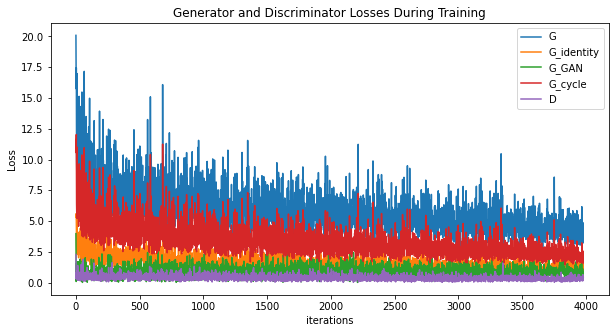

In [23]:
plt.figure(figsize=(10,5))

plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_loss,label="G")
plt.plot(G_identity_loss,label="G_identity")
plt.plot(G_gan_loss, label="G_GAN")
plt.plot(G_cycle_loss, label="G_cycle")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

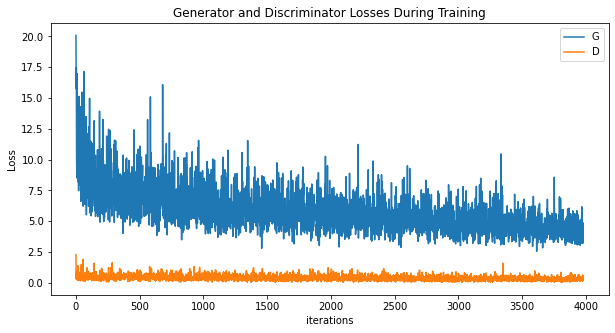

In [24]:
plt.figure(figsize=(10,5))

plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

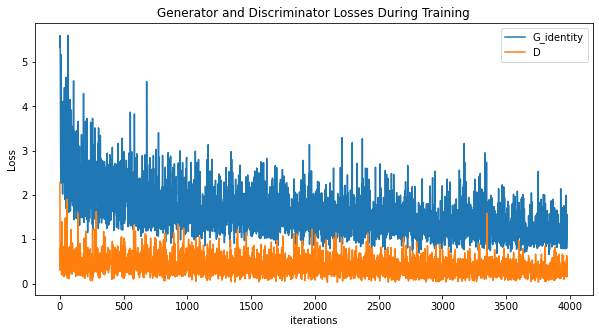

In [25]:
plt.figure(figsize=(10,5))

plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_identity_loss,label="G_identity")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

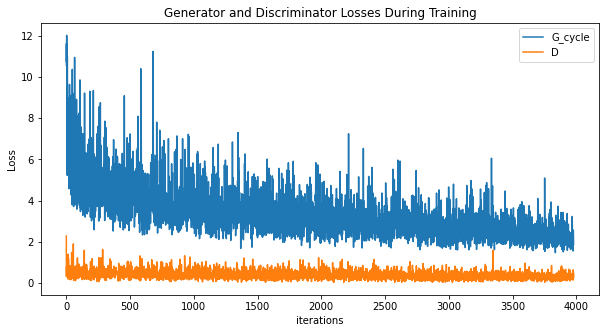

In [26]:
plt.figure(figsize=(10,5))

plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_cycle_loss, label="G_cycle")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

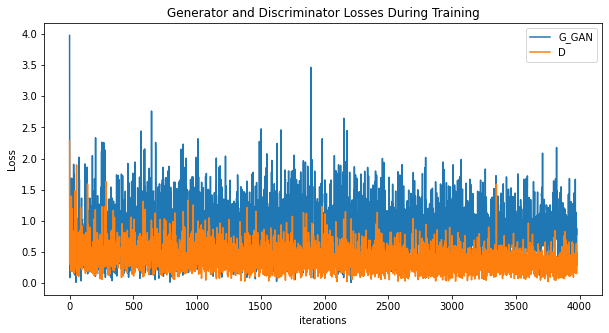

In [27]:
plt.figure(figsize=(10,5))

plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_gan_loss, label="G_GAN")
plt.plot(D_loss, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Testing Time

In [28]:
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
# Load state dicts
netG_A2B.load_state_dict(torch.load(output_dir + '/netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load(output_dir + '/netG_B2A.pth'))

<All keys matched successfully>

In [29]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, 313, 313)
input_B = Tensor(batchSize, output_nc, 313, 313)

transforms_ = [transforms.Resize((313,313), Image.BICUBIC), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, mode='test'), 
                        batch_size=batchSize, shuffle=False, num_workers=n_cpu)
###################################


save_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(218,178)),
    transforms.ToTensor()
])


###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    print(batch['A'].shape)
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    fake_A = fake_A.detach().cpu()
    fake_A = [save_transforms(x_) for x_ in fake_A]
    fake_B = fake_B.detach().cpu()
    fake_B = [save_transforms(x_) for x_ in fake_B]
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')
###################################

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 3, 313, 313])
Generated images 0001 of 0003torch.Size([1, 3, 313, 313])
Generated images 0002 of 0003torch.Size([1, 3, 313, 313])
Generated images 0003 of 0003


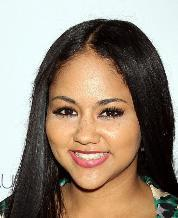

In [31]:
ImageDisplay('/content/drive/MyDrive/DataSets/img_celeba2/preprocessed_dataset_celeba/test/A/000132.jpg')

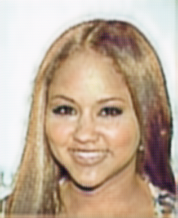

In [40]:
ImageDisplay('/content/output/B/0001.png')

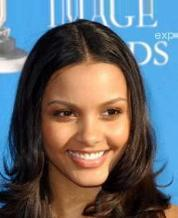

In [32]:
ImageDisplay('/content/drive/MyDrive/DataSets/img_celeba2/preprocessed_dataset_celeba/test/A/001232.jpg')

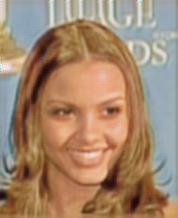

In [41]:
ImageDisplay('/content/output/B/0002.png')

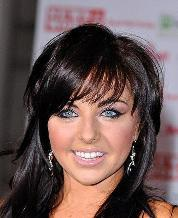

In [33]:
ImageDisplay('/content/drive/MyDrive/DataSets/img_celeba2/preprocessed_dataset_celeba/test/A/001449.jpg')

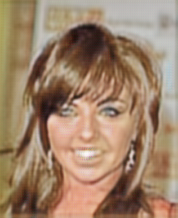

In [42]:
ImageDisplay('/content/output/B/0003.png')

In [43]:
# Not too bad. I trained it with only 2k pics. If I train my model with whole dataset(230k) it would be far better.

In [ ]:
# Done !